## TestTemplate Notebook

This notebook should be used to submit your model for testing on the test set and the submission of you model to the general leaderboard. Please copy it to your own submission folder and fill it in. Please note that it is important that you pip install any dependencies that your model needs so that we can easily run the model. In some cases, you might want to upload an already trained model to be evaluated, instead of training your model from scracth. This is HIGHLY recommended if you use models that take a long time to train, but for small sklearn models it is not very necessary.

## Submission instructions

If you want to submit your model to be tested on the secret test sets, please implement your model in this 'SubmitRun' notebook, and make sure it works on the sample data. It is easiest to just download the 'Competition' folder for this and check that everything works. If so, please put your notebook and any other files you need (like trained model files). 

In [1]:
# Please install any packages you need in this cell
# For example: !pip install sklearn

!pip install sklearn
!pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
!pip install transformers
path_to_competition_folder = '/Users/williampham/Desktop/Competition'

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu


In [2]:
!pip install tokenizers

In [3]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display, Markdown

# Metric import
import metricutils

# import any packages your code might need here
# Put any imports here
from tqdm import tqdm
# import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

You will not have access to the test folder with the test data from both corpora, but you can test that your model will run properly with some samples that we have provided for you in the 'sample_data' directory.

## Adjusting paths

Depending on where you put hour notebook relative to the data, you might have slighly different paths to the training and sample data. To ensure the code works, please adjust the path in the cell below to point to the 'Competition' folder. In this case of this notebook, the path is just one folder up, so '../'. You can use either absolute or relative paths.

In [4]:
path_to_competition_folder = '/Users/williampham/Desktop/Competition'

In [5]:
import re
import nltk
# import pypdfium2
# import pytesseract
import numpy as np
import pandas as pd

import json
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
try:
    import torch
    import torch.nn.functional as F
except:
    import torch
    import torch.nn.functional as F

try:
    from transformers import AutoTokenizer
except:
    !pip install transformers
    from transformers import AutoTokenizer

%matplotlib inline

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
torch.device("mps")
torch.__version__

'1.13.0.dev20220611'

In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from networks.vgg_bert_custom import vgg_bert

In [8]:
feature_length = 1024
device = torch.device('cpu')

model_bert = vgg_bert(in_ch=3, out_ch=2)
model_bert = model_bert.to(device)

model_bert = torch.nn.DataParallel(model_bert)

weight = torch.load('models/focal_bert_newdata_100/best_val_loss.pt', map_location=device)
model_bert.load_state_dict(weight, strict=True)

bert_tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased", revision="v1")

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.poole

In [9]:
# This function can be used to load the pdf file names, gold standard json and the text dataframe
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def get_bert_tokenizer(text):
    bert_input = bert_tokenizer(text, padding='max_length', max_length=256,
                               truncation=True, return_tensors="pt")
    _id = bert_input['input_ids']
    _mask = bert_input['attention_mask']
    return _id, _mask

def tag_page(prediction):
    """
    :param prediction: classify prediction array: e.g [1, 0, 0, 1, 0, 0, 1, 0, 1]
    :return: tag page: e.g. [3, 3, 2, 1]
    """
    tag = np.split(prediction, np.argwhere(prediction == 1).flatten())
    tag = [len(tag[i]) for i in range(len(tag)) if len(tag[i])]
    tag = np.array(tag)

    return tag

def cleanText(text):
    text = BeautifulSoup(text, "html.parser").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'\\n', r' ', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

def resize_normalize_image(image, img_size=224):
    height, width, _ = image.shape
    if height > width:
        scale = img_size / height
        resized_height = img_size
        resized_width = int(width * scale)
    else:
        scale = img_size / width
        resized_height = int(height * scale)
        resized_width = img_size

    image = cv2.resize(image, (resized_width, resized_height), interpolation=cv2.INTER_LINEAR)

    new_image = np.zeros((img_size, img_size, image.shape[2]))

    offset_w = (img_size - resized_width) // 2
    offset_h = (img_size - resized_height) // 2
    new_image[offset_h:offset_h + resized_height, offset_w:offset_w + resized_width] = image
    return new_image/255.0


def get_data(data_path, train=True):
    """
    This function takes as input the path to either train_data or test_data, and combines
    the information present in the corpus1 and corpus2 subfolders to allow
    you to train on the all the data. the output is a dict containing the dataframe with the text,
    and a 'png' column to the path of the png files belonging to each file. It also contains the gold standard in
    binary vector format.
    
    """
    if train:
        gold_standard_path = '%s/Doclengths_of_the_individual_docs_TRAIN.json' % data_path
    else:
        gold_standard_path = '%s/Doclengths_of_the_individual_docs_TEST.json' % data_path       
    
    dataframe = pd.read_csv('%s/ocred_text.csv.gz' % data_path)
    with open(gold_standard_path, 'r') as json_file:
        gold_json = json.load(json_file)
    
    # Add the png column
    png_column = dataframe['name'] + '-' + dataframe['page'].astype(str) + '.png'
    
    # Make sure it points to the correct path
    png_column_joined = os.path.join(data_path, 'png') + os.sep + png_column
    dataframe['png'] = png_column_joined
    
    binary_gold = {key: metricutils.length_list_to_bin(val) for key, val in gold_json.items()}
    # oh

    return {'csv': dataframe.sort_values(by=['name', 'page']), 'json': binary_gold}


def get_train_data(data_path):
    """
    This function takes as input the path to 'train_data' and combined
    the information present in the corpus1 and corpus2 subfolders to allow
    you to train on the all the data.
    """
  # We train on both corpus 1 and corpus 2
    c1_path = os.path.join(data_path, 'corpus1')
    c2_path = os.path.join(data_path, 'corpus2')
        
        
    c1_data = get_data(c1_path, train=True)
    c2_data = get_data(c2_path, train=True)

    combined_dataframe = pd.concat([c1_data['csv'], c2_data['csv']])
    combined_json = {**c1_data['json'], **c2_data['json']}
    combined_pdfs = c1_data['pdf'] + c2_data['pdf']
    
    return {'csv': combined_dataframe.sort_values(by=['name', 'page']), 'json': combined_json}

def data_loader(df):
    df.fillna('', inplace=True)
    df['text_processed'] = df['text'].apply(cleanText)
    path = df['png'].tolist()
    text = df['text_processed'].tolist()
    # labels = df['labels']
    # label = df['labels'].tolist()
    return path, text

def get_sample_data(data_path):
    """
    This function takes as input the path to the 'sample_data' folder,
    and outputs a dictionary with the text dataframe, the gold standard json and
    the paths to the pds.
    """
    dataframe = pd.read_csv('%s/sample.csv' % data_path)

    dataframe.fillna('', inplace=True)
    dataframe['text_processed'] = dataframe['text'].apply(cleanText)

    with open('%s/sample.json' % data_path, 'r') as json_file:
        gold_json = json.load(json_file)

    # Add the png column
    png_column = dataframe['name'] + '-' + dataframe['page'].astype(str) + '.png'
    
    # Make sure it points to the correct path
    png_column_joined = os.path.join(data_path, 'png') + os.sep + png_column
    dataframe['png'] = png_column_joined
        
    binary_gold = {key: metricutils.length_list_to_bin(val) for key, val in gold_json.items()}

    return {'csv': dataframe.sort_values(by=['name', 'page']), 'json': binary_gold}

## Setting up the model

Unless you are loading in a trained model, this is where you want to insert the code to train your model.

The data is provided as a dictionary with three entries: `{'csv': _, 'json'}`.csv contains the loaded in csv file, json contains the gold standard json in binary format.

We are going to follow an approach that is similar to that of SKLearn, where you make a model that has `train` and `predict` functions. The function to score a modle will be provided by us.

Please also read the `Evaluation` notebook on the surdrive carefully, it shows how the metrics are calculated and what your format should be. Your model should return a dictionary where each key is the document ID and the value is the stream in binary vector format.

In [10]:
# we already got the model trained, so deleted this part

## Training the model (optional)

If your model requires trainin you can put this boolean to true. If not, you can leave it as-is.

In [11]:
# no need for training

## Checking the model

For this we will make a prediction with the model on the sample data, and see how whether it works and gives us some scores. Please also add a descriptive name of your model below (preferably also containing your name), this will be used as a title of the plots shown on the test sets, and helps us keep it clear which plots came from which models.

In [12]:
short_model_description = "VGG-BERT"

In [13]:
run_on_test = False

In [14]:
from tqdm import tqdm

class Prediction():
    def __init__(self, path, text):
        self.path = path
        self.text = text
        self.output = []

    def run_batch(self):
        result = []
        for i in tqdm(range(len(self.path))):
            fname = self.path[i]
            image = cv2.imread(fname)
            text = self.text[i]
            predict = self.run_single(image, text)
            result.append(predict)
        result = np.array(result)
        return result


    def run_single(self, image, text):
        b_id, b_mask = get_bert_tokenizer(text)
        b_id = b_id.to(device)
        b_mask = b_mask.to(device)
        
        image = resize_normalize_image(image)
        image = torch.from_numpy(image).float()
        image = torch.unsqueeze(image, dim=0)
        image = image.permute(0, 3, 1, 2)
        image = image.to(device)
        
        with torch.no_grad():
            prediction = model_bert(image, b_id, b_mask)
            prediction = F.softmax(prediction, dim=1)
            prediction = torch.argmax(prediction, dim=1)
            
        prediction = prediction.cpu().numpy()
        return float(prediction.item())

In [15]:
data = get_sample_data(os.path.join(path_to_competition_folder, 'sample_data'))
df = data['csv']
keys = list(df['name'].unique())

predictions = {}
for k in keys:
    sm_df = df[df['name'] == k]
    path, text = data_loader(sm_df)
    model_predict = Prediction(path=path, text=text)
    prediction = model_predict.run_batch()
    predictions[k] = prediction
    


<ipython-input-9-1597260ae351>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna('', inplace=True)
<ipython-input-9-1597260ae351>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_processed'] = df['text'].apply(cleanText)
100%|██████████| 249/249 [02:56<00:00,  1.41it/s]


In [16]:
predictions

{'892231__concatenated': array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 0.]),
 '963330_bijlagen.zip__concatenated': array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

<b>Scores for the model on the sample data</b>

<b> Mean scores of the evaluation metrics for VGG-BERT </b>

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Boundary,0.46,0.94,0.50,19.0,0.29-0.63,0.86-1.02,0.33-0.67
Bcubed,1.00,0.54,0.62,19.0,1.0-1.0,0.37-0.71,0.45-0.79
WindowDiff,0.32,0.32,0.32,19.0,0.16-0.48,0.16-0.48,0.16-0.48
Block,0.32,0.33,0.32,19.0,0.16-0.48,0.17-0.49,0.16-0.48
Weighted Block,0.37,0.39,0.38,19.0,0.2-0.54,0.22-0.56,0.21-0.55


<b> KDE Plots of the scores of the evaluation metrics for VGG-BERT </b>

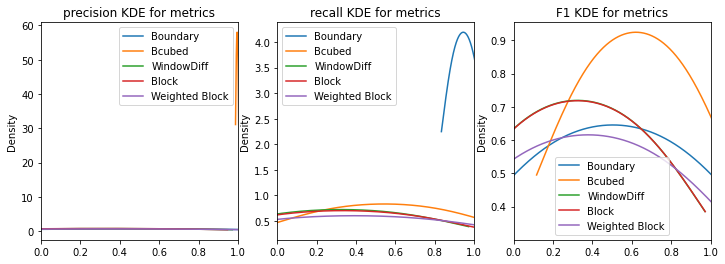

In [17]:
if run_on_test:
    pass
    # we don't use run on test
else:
    display(Markdown("<b>Scores for the model on the sample data</b>"))
    metricutils.evaluation_report(data['json'], predictions, title=short_model_description)